# Related Work recommandation system for research papers

In [ ]:
################################################################
# Get the libraries
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
import ipywidgets as widgets
from IPython.display import display
import logging
import pandas as pd
import numpy as np
import ast
import random
from tqdm import tqdm
import logging
import ast
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import logging
import ast
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import json
import logging
import sys
from tqdm import tqdm
from sklearn.manifold import TSNE
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import os

plt.style.use(['science', 'notebook', 'grid'])


In [2]:
from src.preprocessing import DataPreprocessor

##  Get data


Source : https://www.kaggle.com/datasets/nechbamohammed/research-papers-dataset

The dataset is obtained from the kaggle platform and it gives little context about the selection process and its temporality.

One important aspect of every Machine Learning project is the Data Quality Analysis. This means that *before starting to analyse the data* we want to ensure that the dataset reflects the reality, meaning that it is :
1. Valid
2. Reliable

This is why we will create a sort of data dictionary that will allow us to define data quality rules, think about the expected data types and list the coherence rules to check. This way, we will ensure we work will data that reflect reality and that we know how to adequatly exploit and interpret them.

NB : Even though the data quality is differently measured between tabular numerical data and the textual ones, there are certain "common sense" rules we should be able to confirm before modelling.



In [3]:
df = DataPreprocessor.read_csv("dblp-v10.csv")
#https://huggingface.co/datasets/minagoranovic/research_papers/tree/main
df.shape

Loaded dataset from 'dblp-v10.csv'.


(1000000, 8)

| col_name     | description                                     | dtype          | value rules                          | DQ rules                                       | example value |
|--------------|-------------------------------------------------|----------------|--------------------------------------|-----------------------------------------------|---------------|
| abstract         | Paper abstract text                      | string         | free format                     | Always assigned                                | 'In this paper, a robust 3D triangular mesh watermarking algorithm based on 3D segmentation is proposed. In this algorithm three classes of watermarking are combined. First, we segment the original image to many different regions. Then we mark every type of region with the corresponding algorithm based on their curvature value. The experiments show that our watermarking is robust against numerous attacks including RST transformations, smoothing, additive random noise, cropping, simplification and remeshing.'
| authors          | List of authors of the paper                   | string        | ['Name Lastname1', 'Name Lastname2', ...]               | Always assigned, same name always in the same format                                | "['S. Ben Jabra', 'Ezzeddine Zagrouba']"        |
| n_citation          | Number of citations at the sampling date                         |  integer        | non-negative              | Always assigned                             | 50          |
| references          | List of paper_ids of all papers references in the paper                                 | string        | ['paperid1', 'paperid2', ...]                 | Always assigned                                | "['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa16da-3cc8-4af6-9d66-48037e915d76', '35cb45c3-9408-4096-ab30-bc2e4de3fb5d', '661a342e-a911-4420-b67d-51c75d3b14e9', '779553f3-e4c1-456e-bc01-5eb9d9567541', 'b24ba5c0-fee8-4a3e-9330-17f6564856cd', 'fd1c676d-1296-4f19-89b4-17c7ecd270f3']"           |
| title          | Official title of the paper                            | string        | free format                 | Always assigned                                | 'A new approach of 3D watermarking based on image segmentation'           |
| venue          | Name of conference where the paper was submitted                         | string        | free format                 | Not always assigned                                | 'international symposium on computers and communications'           |
| year          | Year of publishing                          | integer        | <= 19000 <= 2025               | Always assigned        | 2008          |
| id       | Paper identifier                     | string        | Unique                 | Always assigned                                | 	4ab3735c-80f1-472d-b953-fa0557fed28b           |


In [ ]:
df.head()

# 1. Data quality

In this section we confirm (or not) the rules we assumed in the data dictionary above. We take appropriate actions for each analysis we take.

## 1.1. Nan check

- Where do we have not assigned data and does it bother us?


In [5]:
for col in df.columns:
    df[col] = df[col].replace(["", " ", "NA", "null", "N/A", 'Nan'], pd.NA)
    DataPreprocessor.check_for_nans(df, col)

'abstract' contains 17.25% NaNs.
'authors' contains 0.00% NaNs.
'n_citation' contains 0.00% NaNs.
'references' contains 12.44% NaNs.
'title' contains 0.00% NaNs.
'venue' contains 17.78% NaNs.
'year' contains 0.00% NaNs.
'id' contains 0.00% NaNs.


In [ ]:
df[df['abstract'].isna()]

In [7]:
df = df.dropna(subset=['abstract'])
df[df['abstract'].isna()]

,abstract,authors,n_citation,references,title,venue,year,id


In [8]:
df[df['authors'].isna()]

,abstract,authors,n_citation,references,title,venue,year,id
594452,This paper proposes a new intra-mode decision ...,NaN,1,"['1a6ecea3-bad3-4139-8c15-9a35247b8be4', '93cf...",An efficient intra-mode decision method for HEVC,"Signal, Image and Video Processing",2016,9c4cf6a4-3d7a-4892-9acd-dc30336c73f1


In [9]:
df = df.dropna(subset=['authors'])
df[df['authors'].isna()]

,abstract,authors,n_citation,references,title,venue,year,id


In [10]:
df[df['references'].isna()].shape

(40309, 8)

In [11]:
df = df.dropna(subset=['references'])
df = df.dropna(subset=['venue'])

We estimate that abstract and author(s) are the mandatory keys for the paper identification, hence we drop all the rows where one of these is not assigned. We also observe that there is a certain amount of the papers with no reference and we choose to drop them. Lastly, we also decide to drop all the papers that were not presented at a conference.


## 1.2. Value rules
- years format range
- citation number range and type


In [12]:
DataPreprocessor.validate_columns(df)

0.00% of 'year' are out of range 1900-2025.
0.00% of 'n_citation' are not non-negative integers.


## 1.3. Uniqueness check
- unique id column
- unique title column 
- no doubled rows 

In [13]:
df.duplicated().sum()

0

In [14]:
df['id'].duplicated().sum()

0

In [15]:
df['title'].duplicated().sum()

416

In [16]:
df[df['title'].duplicated(keep=False)].sort_values(by='title')

## keep onl the later year ? or the one with more citations ? or the one that ended up at conference ?

,abstract,authors,n_citation,references,title,venue,year,id
202848,Recovering camera orientation with respect to ...,['Ali R. Bani-Hashemi'],50,"['2340a3b7-155f-4c9d-80de-fa5b211e617c', '5b3a...",A Fourier approach to camera orientation,IEEE Transactions on Pattern Analysis and Mach...,1993,8dfb27e2-32fa-44d6-804e-aa815c91b38b
119292,A Fourier technique to determine the orientati...,['Ali R. Ban-Hashemi'],50,"['2340a3b7-155f-4c9d-80de-fa5b211e617c', '5b3a...",A Fourier approach to camera orientation,international conference on robotics and autom...,1992,72556faf-8923-49c8-9087-ce2b3315e03f
636111,A jump inversion theorem for the degree spectr...,['Alexandra A. Soskova'],50,"['27a6de83-4ece-42ac-be6e-76507e7609e3', '31fa...",A Jump Inversion Theorem for the Degree Spectra,conference on computability in europe,2007,23f5ec63-a47e-4b94-a105-d86c2f9955c9
294446,"In the present article, we continue the study ...","['Alexandra A. Soskova', 'Ivan N. Soskov']",15,"['27a6de83-4ece-42ac-be6e-76507e7609e3', '732c...",A Jump Inversion Theorem for the Degree Spectra,Journal of Logic and Computation,2009,ac6cc71c-7890-440a-abfc-1652d20b08d4
882495,Biosimulation models are used to understand th...,"['Muntazir Mehdi', 'Yasar Khan', 'Joao Jares',...",0,"['6bc24ead-7981-4616-8f9f-762a8caace8a', 'b89d...",A Linked Data Visualiser for Finite Element Bi...,International Journal of Semantic Computing,2016,848d5d6d-11b5-46c4-bcb8-7c5889a290d7
...,...,...,...,...,...,...,...,...
496763,Monitoring and analyzing network traffic usage...,"['Graham Cormode', 'S. Muthukrishnan']",234,"['01792eda-2379-42b2-a242-ad270a386977', '04d5...",What's new: finding significant differences in...,IEEE\/ACM Transactions on Networking,2005,efce80e0-3637-495f-88a2-11adcc1b8f92
320245,"This paper proposes COPE, a new architecture f...","['Sachin Katti', 'Hariharan Rahul', 'Wenjun Hu...",1096,"['08d1d86c-6975-42cd-813f-9fa74d60cca7', '0d9b...",XORs in the air: practical wireless network co...,IEEE\/ACM Transactions on Networking,2008,b521905b-fff9-4d69-9a80-ac98f0b86d9d
459681,"This paper proposes COPE, a new architecture f...","['Sachin Katti', 'Hariharan Rahul', 'Wenjun Hu...",3501,"['08d1d86c-6975-42cd-813f-9fa74d60cca7', '0d9b...",XORs in the air: practical wireless network co...,acm special interest group on data communication,2006,e36154cf-678a-463e-9dbd-27aca4d7420f
356041,"This paper proposes vGPRS, a voice over IP (Vo...","['Ming-Feng Chang', 'Yi-Bing Lin', 'Ai-Chun Pa...",4,[],vGPRS: a mechanism for voice over GPRS,Wireless Networks,2003,c0fb838a-c2cb-4be5-9715-40c26156a74f


In [17]:
df = df.sort_values(by=['title', 'year'])  
df = df.drop_duplicates(subset='title', keep='first')  # Keep the first published paper

In [18]:
df.shape

(693206, 8)

## Save cleaned dataset

In [19]:
df.shape

(693206, 8)

In [20]:
DataPreprocessor.save_df_to_csv(df, './', 'research_papers_cleaned.csv')

Saved as './/research_papers_cleaned.csv'


# 2. Exploratory Descriptive Analysis - EDA

In [2]:
df = pd.read_csv('research_papers_cleaned.csv')

In [22]:
df.shape

(693206, 8)

In [ ]:
from src.analysis import univariate_analysis, plot_correlation_matrix
import seaborn as sns


univariate_analysis(df, 'year')

def univariate_analysis(df, column):
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f"Summary Statistics for {column}:")
        print(df[column].describe())
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        
        # log scal
        sns.histplot(df[column], kde=True, ax=ax[0])
        ax[0].set_title(f"Histogram of {column} (Log Scale)")
        ax[0].set_xscale('log')  #scale
        
        sns.boxplot(x=df[column], ax=ax[1])
        ax[1].set_title(f"Boxplot of {column} (Log Scale)")
        ax[1].set_xscale('log')  
        plt.tight_layout()
        plt.show()
        
    elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'object':
        print(f"Value Counts for {column}:")
        print(df[column].value_counts())
        
        # Bar Chart for categorical data
        plt.figure(figsize=(8, 5))
        sns.countplot(x=df[column], order=df[column].value_counts().index)
        plt.title(f"Bar Chart of {column}")
        plt.xticks(rotation=45)
        plt.show()
    return

univariate_analysis(df, 'n_citation')


In [24]:
df.shape

(693206, 8)

In [25]:
df['venue_numeric'], venue_mapping = pd.factorize(df['venue'])

venue_mapping = dict(enumerate(venue_mapping))
print("Numeric to Venue Mapping:")
print(venue_mapping)


Numeric to Venue Mapping:
{0: 'ubiquitous computing', 1: 'arXiv: Computation and Language', 2: 'database and expert systems applications', 3: 'participatory design conference', 4: 'ACM Sigweb Newsletter', 5: 'arXiv: Computers and Society', 6: 'empirical methods in natural language processing', 7: 'intelligent robots and systems', 8: 'human factors in computing systems', 9: 'web intelligence', 10: 'logic in computer science', 11: 'european test symposium', 12: 'BMC Bioinformatics', 13: 'IEEE Network', 14: 'hawaii international conference on system sciences', 15: 'conference on computer supported cooperative work', 16: 'systems, man and cybernetics', 17: 'IEEE Transactions on Aerospace and Electronic Systems', 18: 'defect and fault tolerance in vlsi and nanotechnology systems', 19: 'national conference on artificial intelligence', 20: 'data compression conference', 21: 'biocomputation, bioinformatics, and biomedical technologies', 22: 'PLOS Computational Biology', 23: 'pacific symposium 

In [26]:
df.shape

(693206, 9)

In [27]:
df.columns

Index(['abstract', 'authors', 'n_citation', 'references', 'title', 'venue',
       'year', 'id', 'venue_numeric'],
      dtype='object')

### Venue analysis


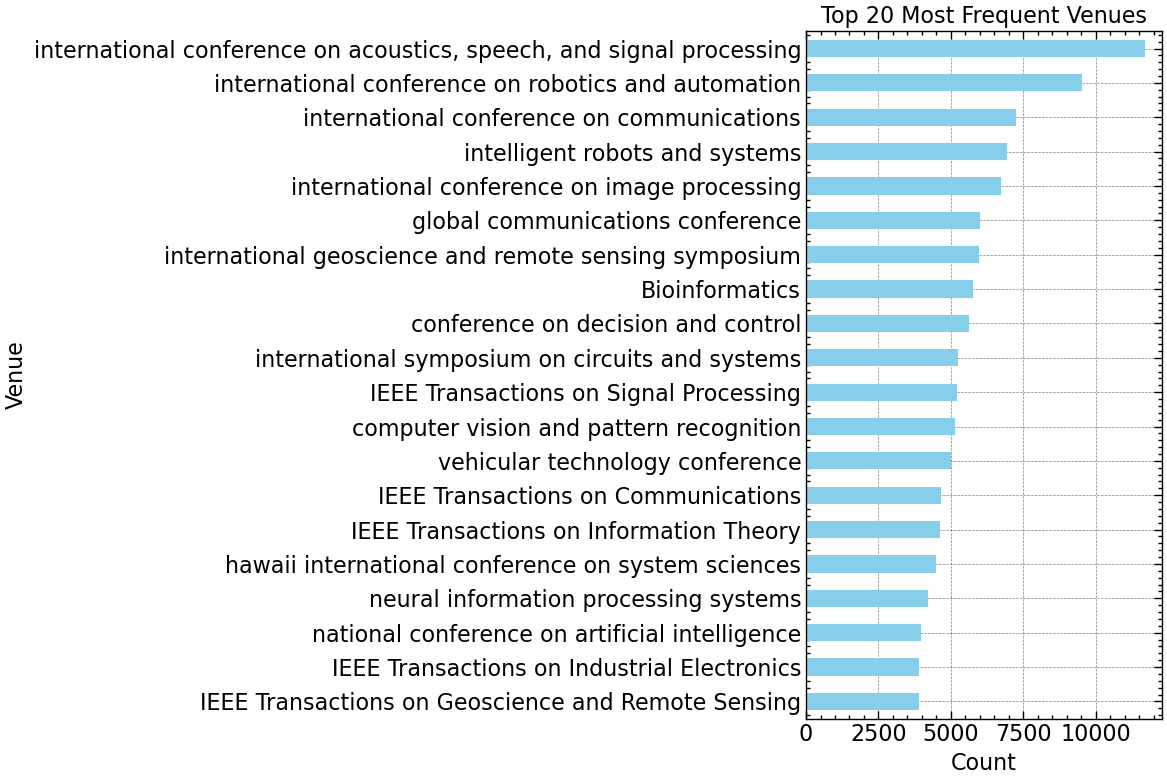

In [28]:
top20_venues = df['venue'].value_counts().head(20)

plt.figure(figsize=(12, 8))
top20_venues.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel("Count")
plt.ylabel("Venue")
plt.title("Top 20 Most Frequent Venues")
plt.tight_layout()
plt.show()

### Authors analysis

In [29]:
print(df['authors'].apply(type).unique())


[<class 'str'>]


In [30]:
import ast

def convert_to_list(author_str):
    try:
        return ast.literal_eval(author_str)
    except Exception as e:
        print(f"Conversion error for: {author_str}\nError: {e}")
        return author_str  

df['authors'] = df['authors'].apply(convert_to_list)

print(df['authors'].apply(type).unique())

[<class 'list'>]


In [31]:
df_exploded = df.explode('authors')

# 1. Top 10 authors by total citations
citations_by_author = df_exploded.groupby('authors')['n_citation'].sum()
top10_authors_citations = citations_by_author.sort_values(ascending=False).head(10)

print("Top 10 Authors by Total Citations:")
print(top10_authors_citations)

# 2. Top 10 authors by total papers published
papers_by_author = df_exploded['authors'].value_counts()

top10_authors_papers = papers_by_author.head(10)

print("\nTop 10 Authors by Number of Papers Written:")
print(top10_authors_papers)


Top 10 Authors by Total Citations:
authors
David G. Lowe        64142
Hari Balakrishnan    54833
Ian F. Akyildiz      53384
Chih-Jen Lin         52158
Ion Stoica           50718
Michael I. Jordan    50473
Scott Shenker        49686
Vladimir Vapnik      49559
Anil K. Jain         48136
Deborah Estrin       45807
Name: n_citation, dtype: int64

Top 10 Authors by Number of Papers Written:
authors
Wei Wang       761
Wei Zhang      519
Lei Zhang      463
Yang Liu       447
Wei Li         444
Lajos Hanzo    429
Jun Wang       422
Jun Zhang      369
Lei Wang       363
Wen Gao        356
Name: count, dtype: int64


### Relevant Literature analysis

0. Delete references that do not appear in the dataset
1. How many papers are quotes on average? Box plot, historgram?
2. What is the average citation count of quoted papers?
3. top most quoted papers in our dataset

In [32]:
df.shape

(693206, 9)

In [ ]:
from src.preprocessing import DataPreprocessor

def process_dataframe_references(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process references in the DataFrame:
      1. Convert 'references' from string to list if needed.
      2. For each row, keep only those references that appear in the 'id' column.
      3. Drop rows with an empty list of references.
    """
    df['references'] = df['references'].apply(
        lambda x: ast.literal_eval(x.strip()) if isinstance(x, str) and x.strip().startswith("[") else x
    )
    
    valid_ids = set(x.strip() for x in df['id'].dropna().astype(str))
    
    df['filtered_references'] = df['references'].apply(
        lambda ref_list: [str(ref).strip() for ref in ref_list if str(ref).strip() in valid_ids]
    )
    
    df = df[df['filtered_references'].apply(len) > 0]
    
    df['references'] = df['filtered_references']
    
    df = df.drop(columns=['filtered_references'])
    
    return df

df_ref = process_dataframe_references(df)



In [34]:
df_ref.shape

(553450, 9)

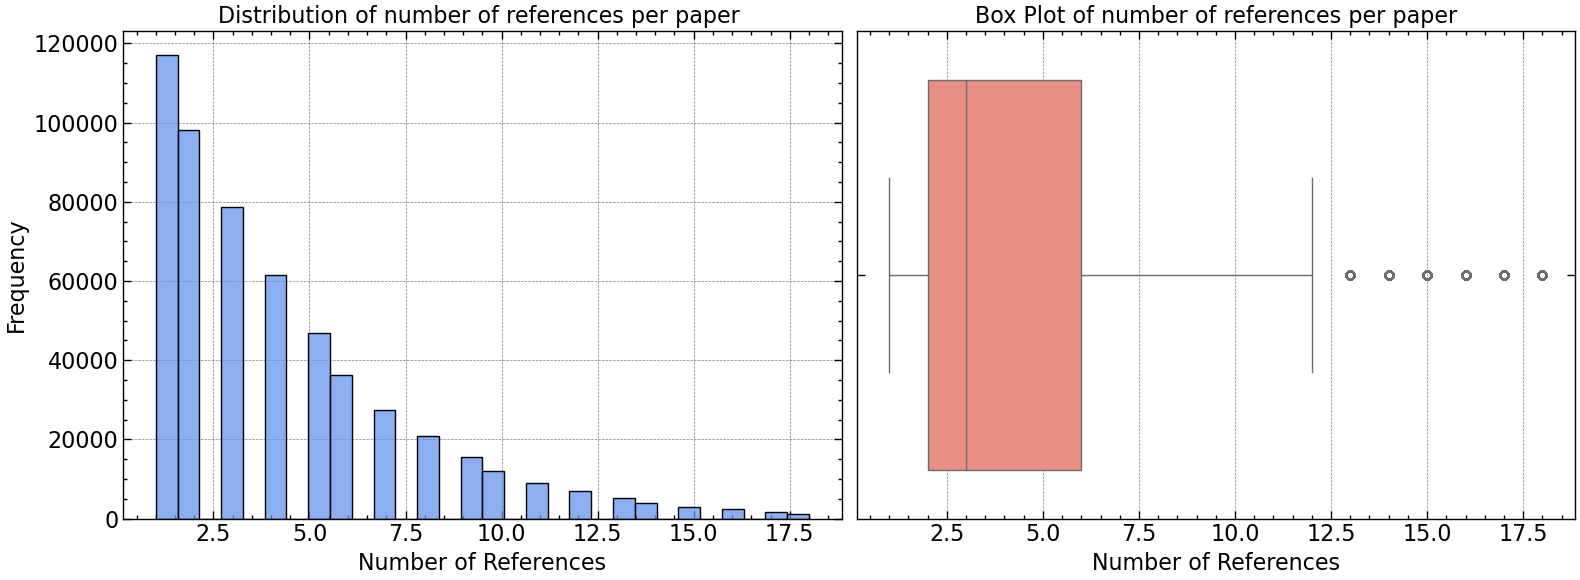

In [35]:
def convert_to_list(ref_str):
    try:
        return ast.literal_eval(ref_str)
    except Exception as e:
        print(f"Conversion error for: {ref_str}\nError: {e}")
        return ref_str 


#df_ref['references'] = df_ref['references'].apply(convert_to_list)

df_ref['num_references'] = df_ref['references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

threshold = df_ref['num_references'].quantile(0.99)

filtered_df = df_ref[df_ref['num_references'] <= threshold]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))


sns.histplot(filtered_df['num_references'], bins=30, ax=axes[0], color='cornflowerblue')
axes[0].set_title("Distribution of number of references per paper ")
axes[0].set_xlabel("Number of References")
axes[0].set_ylabel("Frequency")

sns.boxplot(x=filtered_df['num_references'], ax=axes[1], color='salmon')
axes[1].set_title("Box Plot of number of references per paper")
axes[1].set_xlabel("Number of References")

plt.tight_layout()
plt.show()

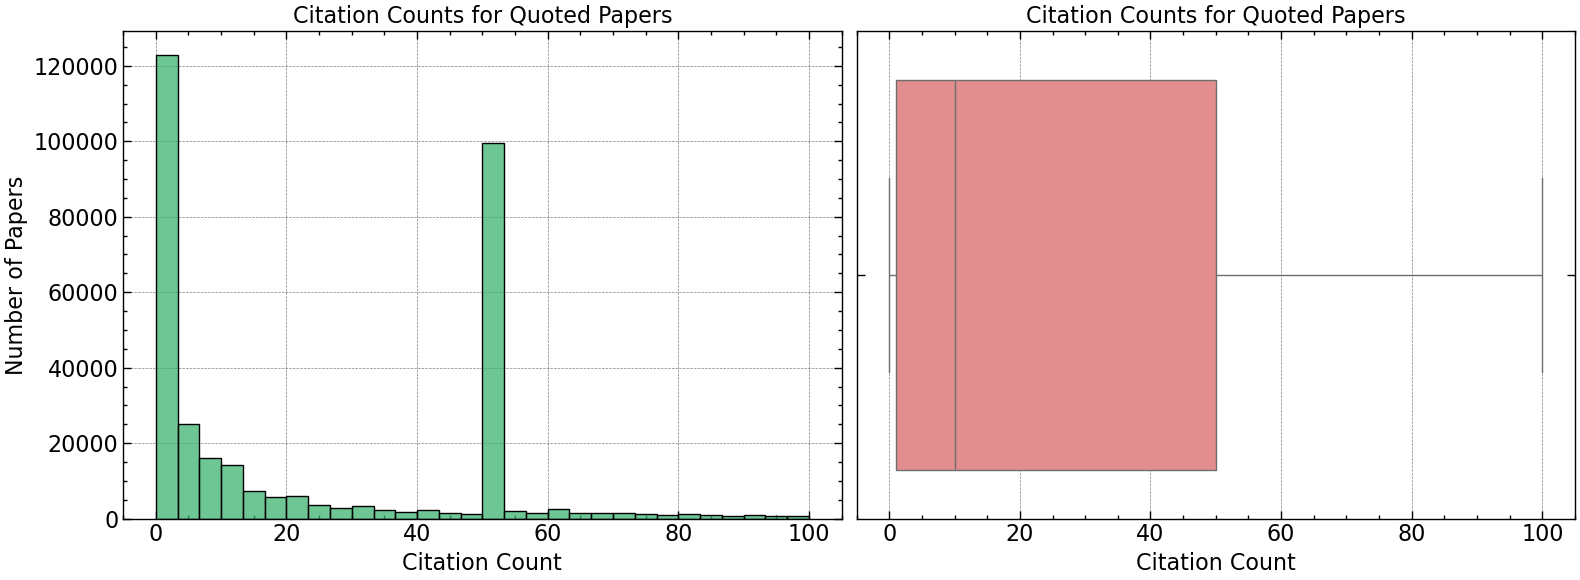

In [36]:
df_exploded_ref = df_ref.explode('references')

df_exploded_ref_unique = df_exploded_ref.drop_duplicates(subset=['references'])

quoted_papers = df_exploded_ref_unique.merge(
    df[['id', 'n_citation']], 
    how='left', 
    left_on='references', 
    right_on='id', 
    suffixes=('', '_quoted')
)

threshold = quoted_papers['n_citation'].quantile(0.95)

filtered_quoted_papers = quoted_papers[quoted_papers['n_citation'] <= threshold]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(filtered_quoted_papers['n_citation'], bins=30, ax=axes[0], color='mediumseagreen')
axes[0].set_title('Citation Counts for Quoted Papers')
axes[0].set_xlabel('Citation Count')
axes[0].set_ylabel('Number of Papers')

sns.boxplot(x=filtered_quoted_papers['n_citation'], ax=axes[1], color='lightcoral')
axes[1].set_title('Citation Counts for Quoted Papers')
axes[1].set_xlabel('Citation Count')

plt.tight_layout()
plt.show()



In [37]:
df_ref.shape, df_exploded_ref.shape, df_exploded_ref_unique.shape

((553450, 10), (2443314, 10), (350928, 10))

In [4]:
df = df_ref

In [5]:
df.shape

(553450, 8)

# 3. NLP Pre-processing 

In [ ]:
from src.analysis import compute_nlp_statistics, plot_nlp_statistics_per_venue

nlp_stats = compute_nlp_statistics(df)
print("Most common words:", nlp_stats['word_counts'].most_common(10))

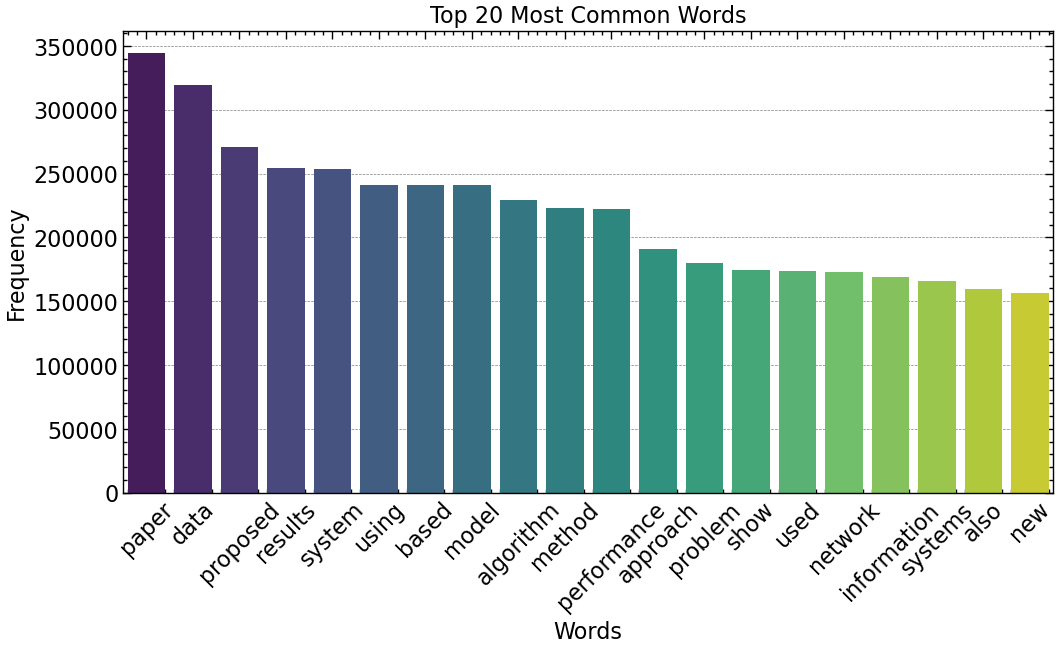

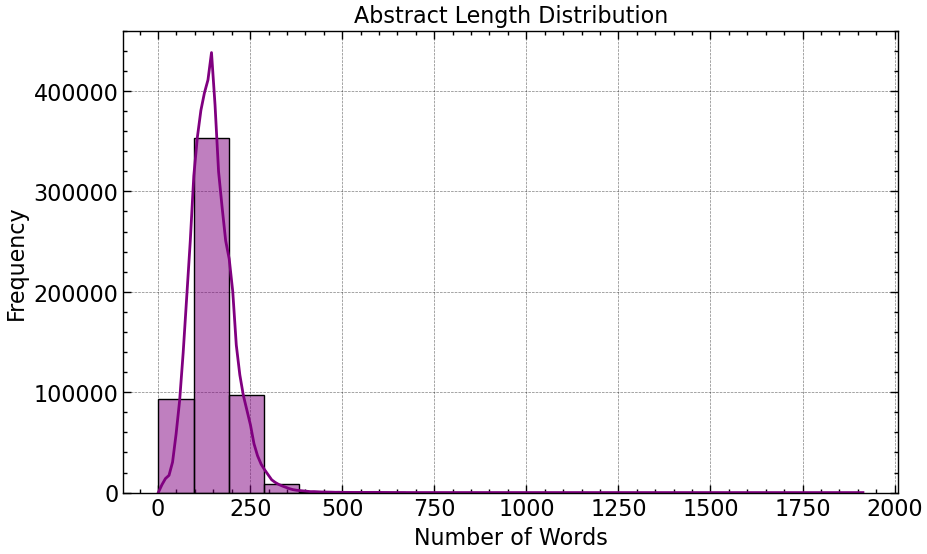

In [43]:
from src.analysis import abstract_length_distribution

abstract_length_distribution(df['abstract'])


In [ ]:
from src.analysis import plot_ngrams
import re 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.util import ngrams
from textstat import flesch_reading_ease

def preprocess_text(text):
    """Preprocesses text by converting to lowercase, removing punctuation, and stopwords."""
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens


def generate_ngrams(texts, n=2, top_n=10):
    """Generates the top N most frequent n-grams."""
    all_ngrams = []
    for text in texts:
        tokens = preprocess_text(text)
        all_ngrams.extend([" ".join(ngram) for ngram in ngrams(tokens, n)])
    
    ngram_counts = Counter(all_ngrams)
    return ngram_counts.most_common(top_n)

def plot_ngrams(df, n=2, top_n=10):
    """Plots the top N bigrams and trigrams smartly."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    bigrams = generate_ngrams(df['abstract'], n=2, top_n=top_n)
    trigrams = generate_ngrams(df['abstract'], n=3, top_n=top_n)
    
    if bigrams:
        words, counts = zip(*bigrams)
        sns.barplot(x=list(counts), y=list(words), ax=axes[0], palette="Blues")
        axes[0].set_title("Top Bigrams")
        axes[0].set_xlabel("Frequency")
    
    if trigrams:
        words, counts = zip(*trigrams)
        sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette="Reds")
        axes[1].set_title("Top Trigrams")
        axes[1].set_xlabel("Frequency")
    
    plt.tight_layout()
    plt.show()

plot_ngrams(df, n=2, top_n=10)

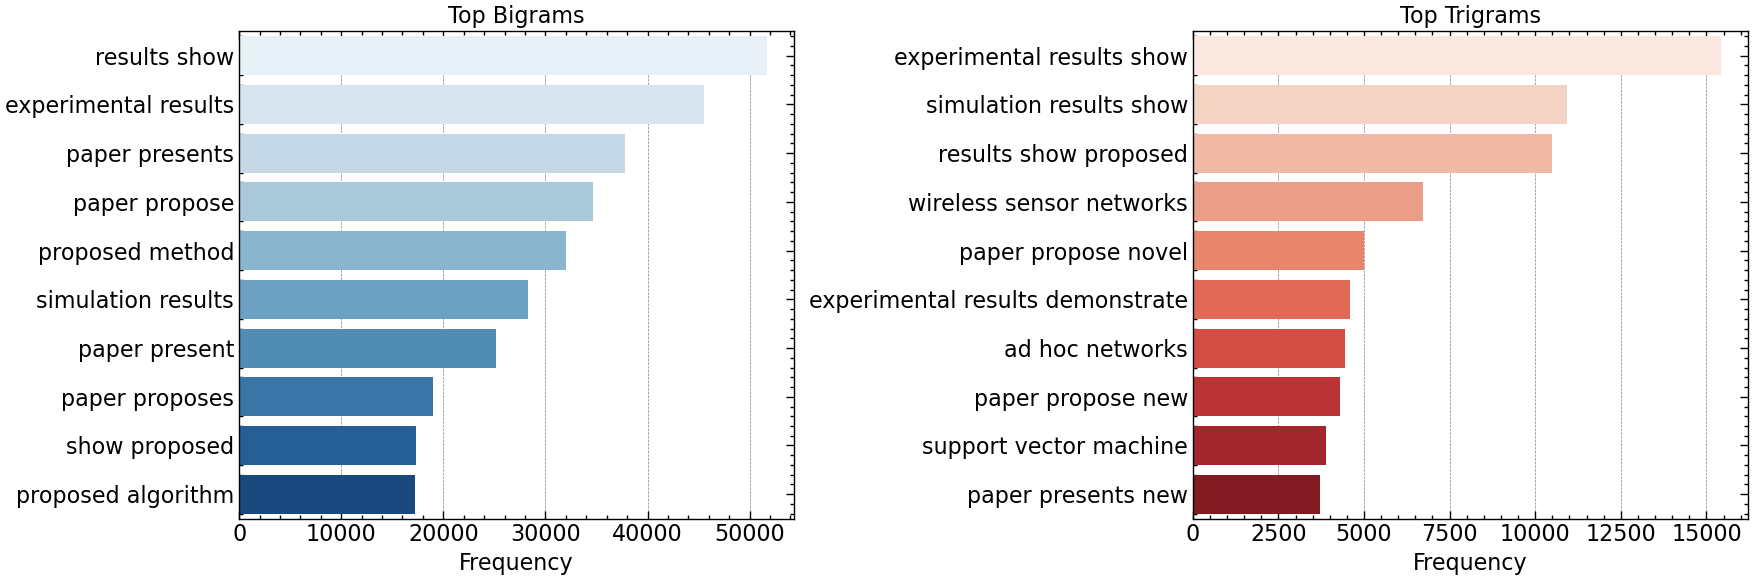

In [45]:
df.head()

,abstract,authors,n_citation,references,title,venue,year,id,venue_numeric,num_references,processed_abstract
0,"A comparative evaluation of smart replicas, ph...","[Daniela Petrelli, Sinead O'Brien]",0,[8955eb8b-f765-49e9-a5cb-6712b0e8e1a2],""" Mobiles for museum visit should be abolished...",ubiquitous computing,2016,06d32272-e765-4936-ae8f-33055b9dc8e9,0,1,comparative evaluation smart replicas phone ap...
4,This paper builds on trajectories in PD that a...,[Shana Agid],0,[c74b2726-3c18-4083-9296-d2c4aa4306a6],"""...it's your project, but it's not necessaril...",participatory design conference,2016,051b98c3-83aa-4cf2-b44e-201d060665bd,3,1,paper builds trajectories pd attend designers ...
5,Users in social networks are often encouraged ...,"[Aleksandr Farseev, Mohammad Akbari, Ivan Samb...",3,"[5d3bc734-97df-4a32-a5d5-eee0cf6a78fe, 6018a51...","""360° user profiling: past, future, and applic...",ACM Sigweb Newsletter,2016,53321964-45fa-41a2-bb61-b2486660d556,4,7,users social networks often encouraged complet...
7,Learning to determine when the timevarying fac...,"[Derry Tanti Wijaya, Ndapandula Nakashole, Tom...",5,"[5cf21bc5-1d26-4705-9b59-0a6200928a9f, a669137...","""A Spousal Relation Begins with a Deletion of ...",empirical methods in natural language processing,2015,df6bc80e-3908-4880-aa95-05540c40b694,6,4,learning determine timevarying facts knowledge...
8,"Cellular Robotic System""CEB0T"" has been studie...","[Yoshio Kawauchi, Toshio Fukuda, Makoto Inaba]",3,[dd308629-deab-45e3-b758-c7ac52cab099],"""A Strategy Of Self-organization For Cellular ...",intelligent robots and systems,1992,50a43613-fae0-430c-90a0-1a300fa48164,7,1,cellular robotic studied realize dynamically r...


## Per venue vision

In [ ]:
plot_nlp_statistics_per_venue(df)

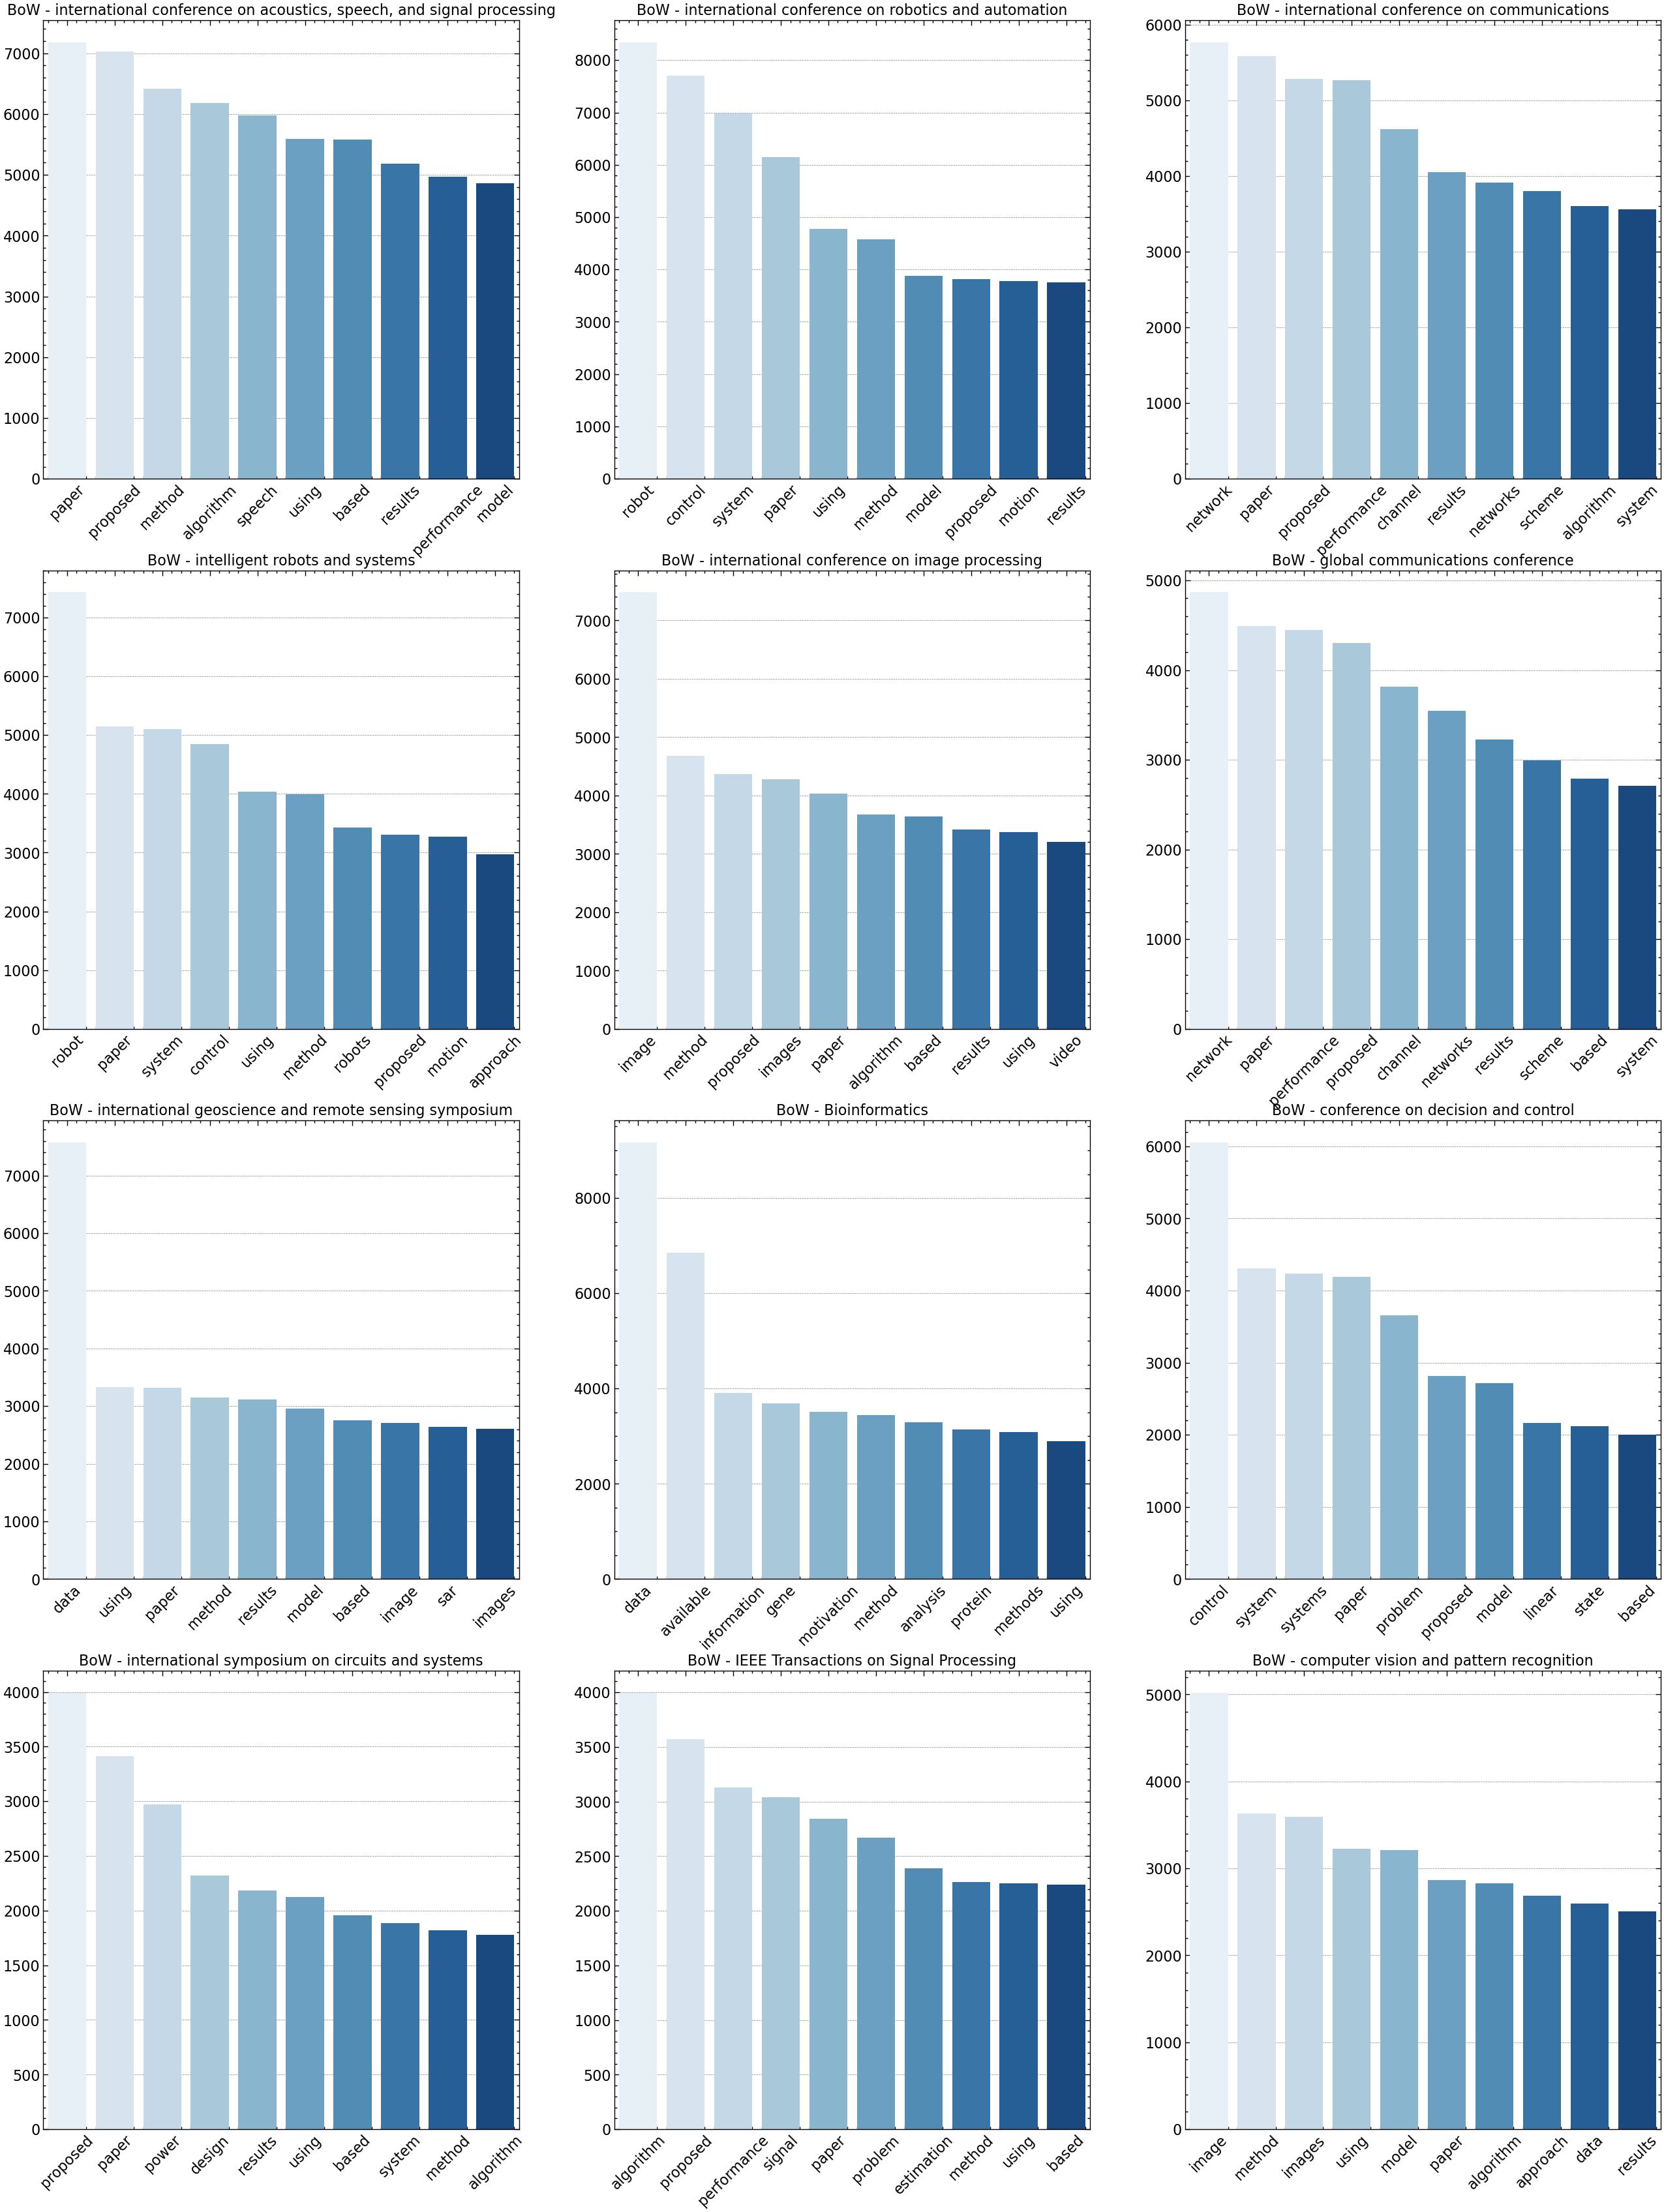
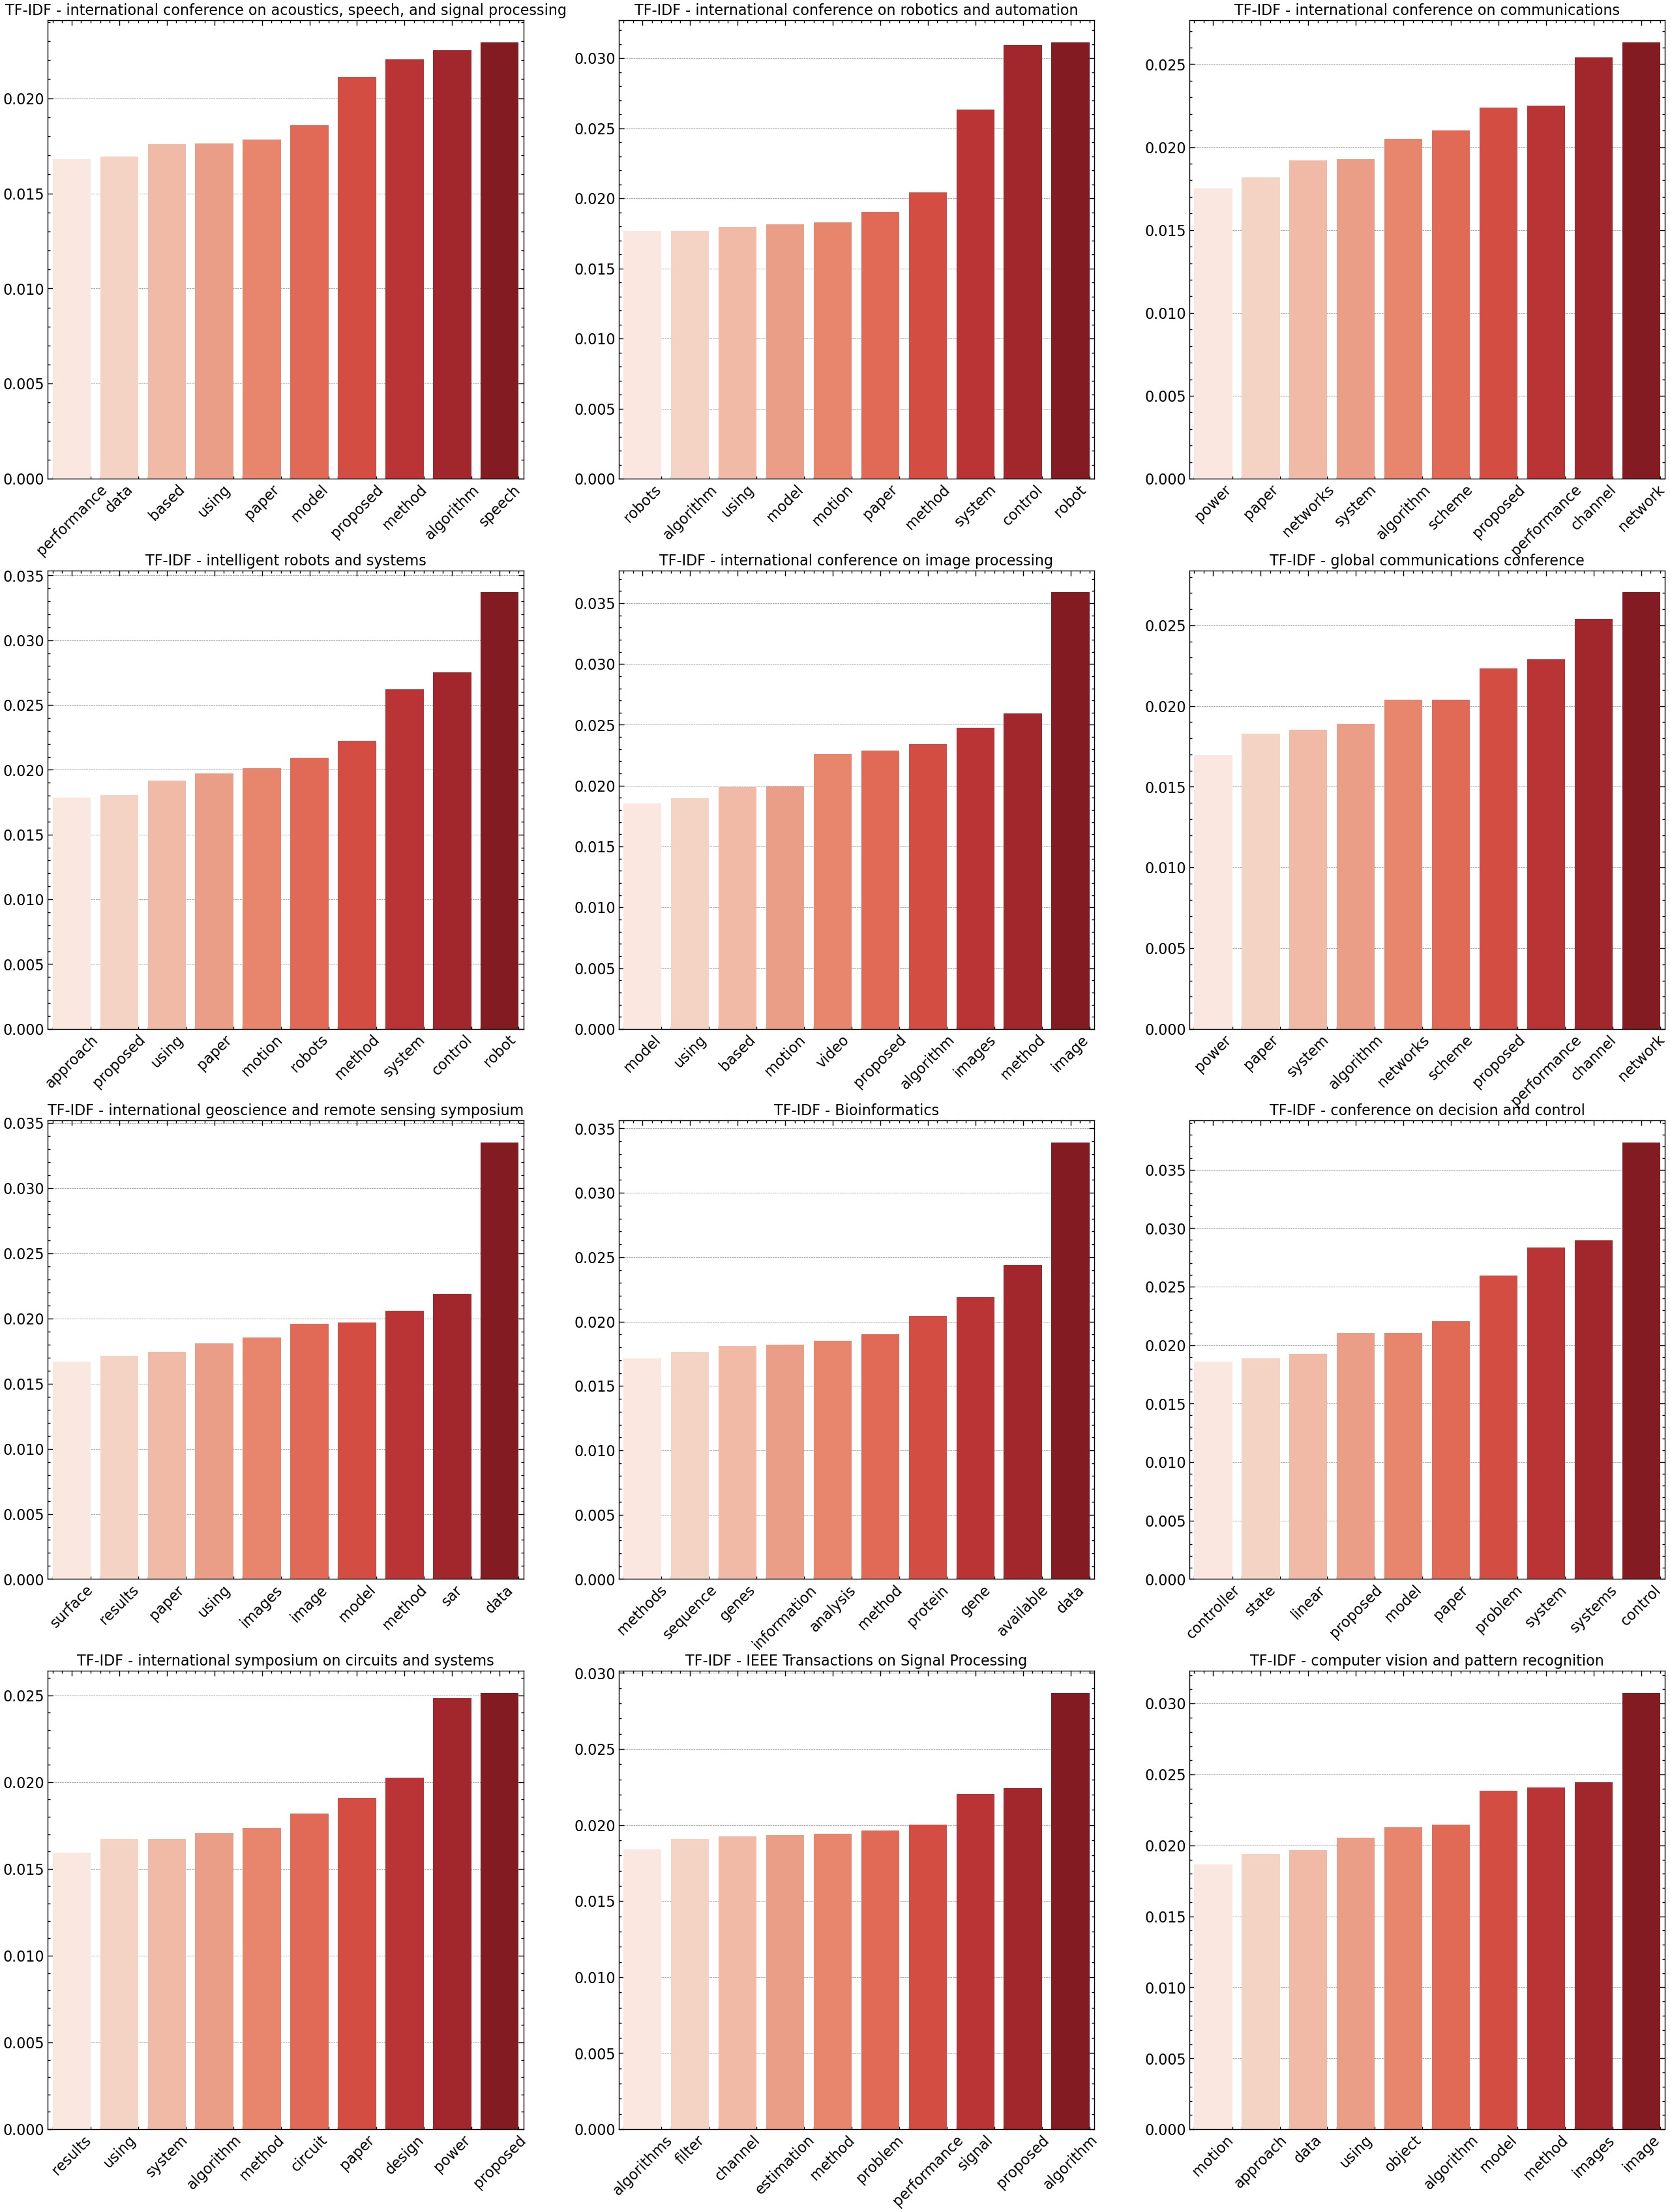

## Understanding Lexical Diversity and Readability Scores




In [ ]:
from src.analysis import plot_lexical_diversity, plot_readability_scores

plot_lexical_diversity(df)
plot_readability_scores(df)


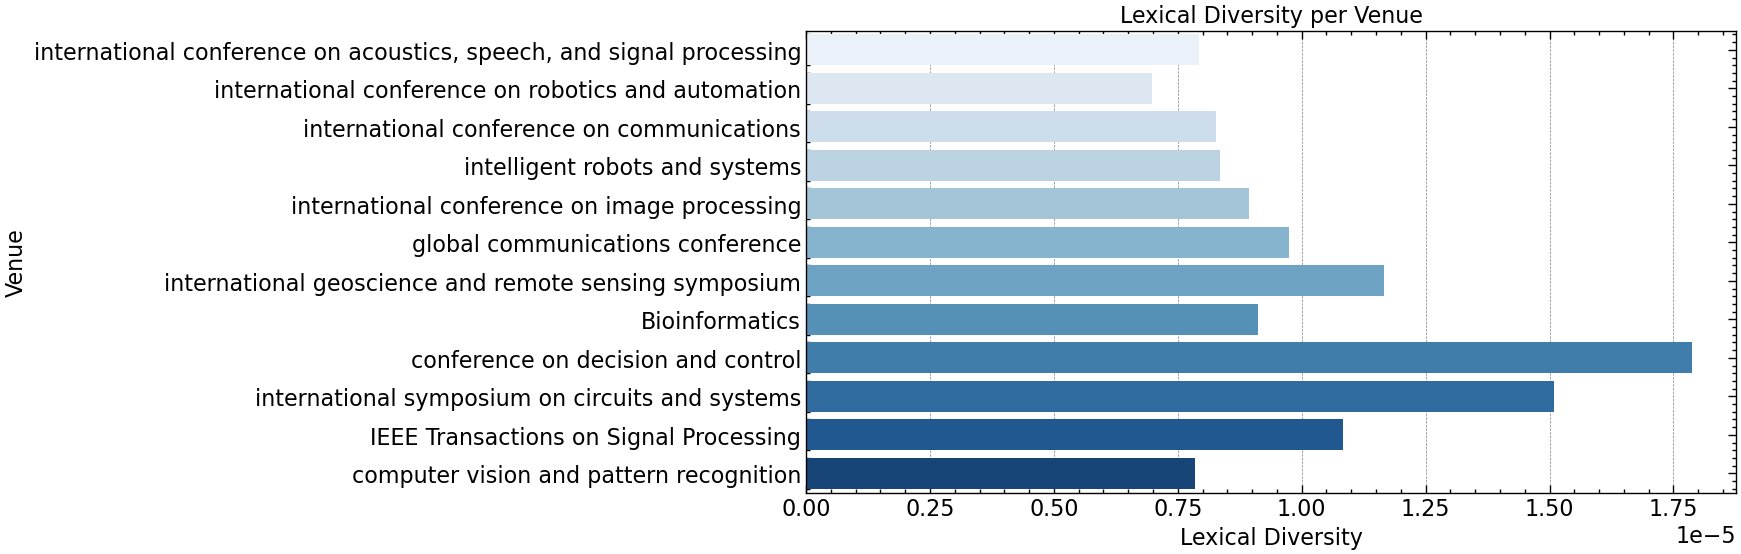
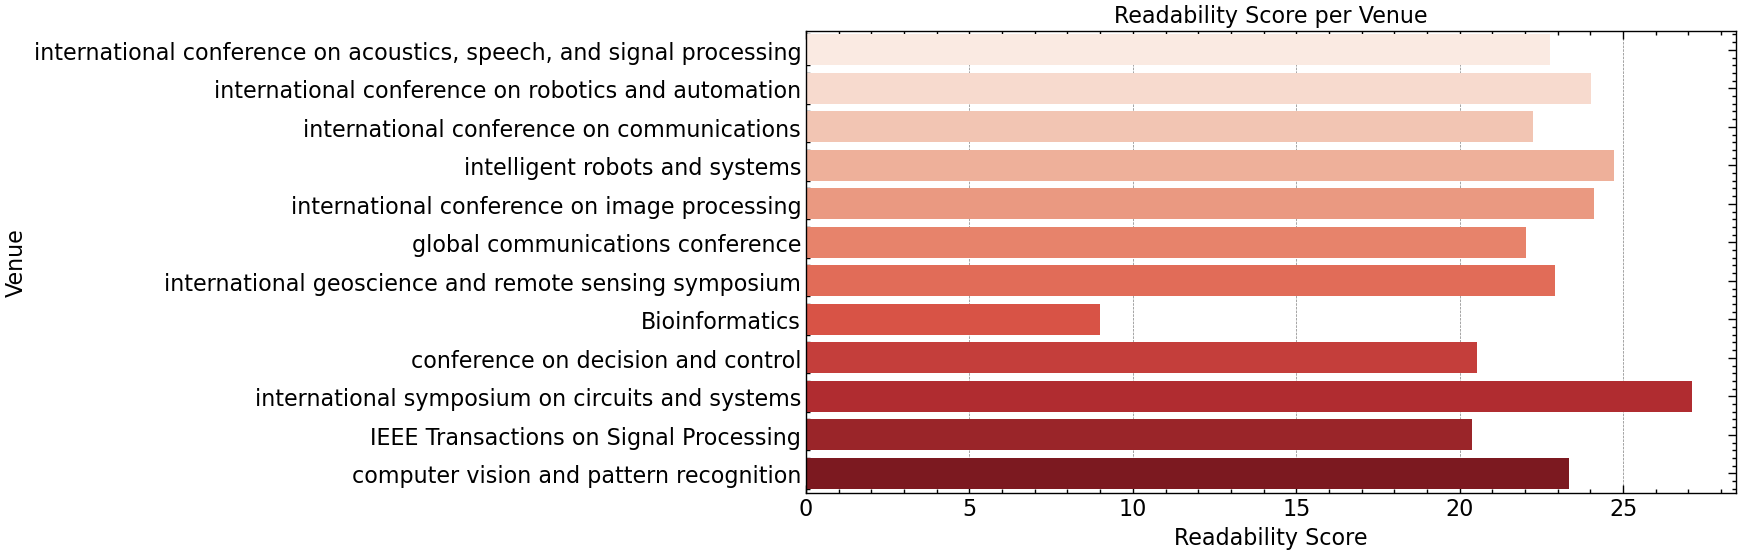

## Abstract Embedding

In [58]:
df = DataPreprocessor.format_abstracts(df)

In [59]:
df.head()


,abstract,authors,n_citation,references,year,id,venue_numeric,num_references,processed_abstract
0,"Title: "" Mobiles for museum visit should be ab...","[Daniela Petrelli, Sinead O'Brien]",0,[8955eb8b-f765-49e9-a5cb-6712b0e8e1a2],2016,06d32272-e765-4936-ae8f-33055b9dc8e9,0,1,comparative evaluation smart replicas phone ap...
4,"Title: ""...it's your project, but it's not nec...",[Shana Agid],0,[c74b2726-3c18-4083-9296-d2c4aa4306a6],2016,051b98c3-83aa-4cf2-b44e-201d060665bd,3,1,paper builds trajectories pd attend designers ...
5,"Title: ""360° user profiling: past, future, and...","[Aleksandr Farseev, Mohammad Akbari, Ivan Samb...",3,"[5d3bc734-97df-4a32-a5d5-eee0cf6a78fe, 6018a51...",2016,53321964-45fa-41a2-bb61-b2486660d556,4,7,users social networks often encouraged complet...
7,"Title: ""A Spousal Relation Begins with a Delet...","[Derry Tanti Wijaya, Ndapandula Nakashole, Tom...",5,"[5cf21bc5-1d26-4705-9b59-0a6200928a9f, a669137...",2015,df6bc80e-3908-4880-aa95-05540c40b694,6,4,learning determine timevarying facts knowledge...
8,"Title: ""A Strategy Of Self-organization For Ce...","[Yoshio Kawauchi, Toshio Fukuda, Makoto Inaba]",3,[dd308629-deab-45e3-b758-c7ac52cab099],1992,50a43613-fae0-430c-90a0-1a300fa48164,7,1,cellular robotic studied realize dynamically r...


In [ ]:
from src.analysis import transform_abstracts_to_embeddings


embeddings = transform_abstracts_to_embeddings(df, method='sentence-transformer')


In [ ]:
DataPreprocessor.save_df_to_csv(embeddings, './', 'abstract_embeddings.csv')

# 4. Modeling the Relevant Literature Predictor

In [ ]:
from src.preprocessing import DataPreprocessor

df= DataPreprocessor.read_csv('abstract_embeddings.csv')

In [52]:
df = df.sort_values(by='year', ascending=True)

In [27]:
class CitationDatasetCreator:
    """Create balanced citation dataset from paper dataframe."""
    
    def __init__(self, target_samples=500000, seed=42):
        """
        Initialize dataset creator.
        
        Args:
            target_samples (int): Total number of samples.
            seed (int): Random seed.
        """
        self.target_samples = target_samples
        self.target_pos = target_samples // 2
        self.target_neg = target_samples // 2
        self.logger = logging.getLogger(self.__class__.__name__)
        self._setup_logging()
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)

    def _setup_logging(self):
        """Configure advanced logging."""
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        fh = logging.FileHandler("dataset_creator.log")
        fh.setFormatter(formatter)
        self.logger.setLevel(logging.DEBUG)
        self.logger.addHandler(sh)
        self.logger.addHandler(fh)

    def _parse_field(self, field):
        """Convert string representation of list to list if needed."""
        if isinstance(field, str):
            try:
                return ast.literal_eval(field)
            except Exception:
                return []
        return field if isinstance(field, list) else []

    def create(self, df):
        """
        Create balanced dataset with paper embeddings and citation label.
        """
        self.logger.info("Building embedding and reference maps")
        embedding_map = {}
        refs_map = {}
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Mapping papers", leave=False):
            paper_id = row['id']
            emb = self._parse_field(row['abstract_embeddings'])
            refs = self._parse_field(row['references'])
            embedding_map[paper_id] = emb
            refs_map[paper_id] = refs
        id_list = list(embedding_map.keys())
        id_set = set(id_list)

        pos_pairs = []
        self.logger.info("Extracting positive pairs")
        for paper_id, refs in tqdm(refs_map.items(), total=len(refs_map), desc="Positive pairs", leave=False):
            for ref in refs:
                if ref in id_set:
                    pos_pairs.append((paper_id, ref, embedding_map[paper_id], embedding_map[ref], 1))
        self.logger.info(f"Found {len(pos_pairs)} positive pairs")
        if len(pos_pairs) > self.target_pos:
            self.logger.info(f"Sampling {self.target_pos} positive pairs")
            pos_pairs = random.sample(pos_pairs, self.target_pos)
        else:
            self.logger.info("Using all available positive pairs")
            self.target_neg = len(pos_pairs)
        pos_set = set((p1, p2) for p1, p2, _, _, _ in pos_pairs)

        neg_pairs = []
        self.logger.info("Generating negative pairs")
        pbar = tqdm(total=self.target_neg, desc="Negative pairs", leave=False)
        while len(neg_pairs) < self.target_neg:
            paper1, paper2 = random.sample(id_list, 2)
            if (paper1, paper2) in pos_set:
                continue
            neg_pairs.append((paper1, paper2, embedding_map[paper1], embedding_map[paper2], 0))
            pbar.update(1)
        pbar.close()

        self.logger.info("Merging and shuffling dataset")
        dataset = pos_pairs + neg_pairs
        random.shuffle(dataset)
        self.logger.info(f"Dataset created with {len(dataset)} samples")
        df_dataset = pd.DataFrame(dataset, columns=['paper1_id', 'paper2_id', 'embedding1', 'embedding2', 'label'])
        return df_dataset




In [28]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("Main")
logger.info("Loading dataframe")

logger.info("Creating citation dataset")

creator = CitationDatasetCreator(target_samples=500000, seed=42)
citation_df = creator.create(df)

logger.info("Saving new dataset")
citation_df.to_csv("citation_dataset.csv", index=False)
logger.info("Process completed")



INFO:Main:Loading dataframe
INFO:Main:Creating citation dataset
2025-02-20 20:43:52,082 - CitationDatasetCreator - INFO - Building embedding and reference maps
2025-02-20 20:43:52,082 - CitationDatasetCreator - INFO - Building embedding and reference maps
INFO:CitationDatasetCreator:Building embedding and reference maps
2025-02-20 20:50:44,564 - CitationDatasetCreator - INFO - Extracting positive pairs
2025-02-20 20:50:44,564 - CitationDatasetCreator - INFO - Extracting positive pairs
INFO:CitationDatasetCreator:Extracting positive pairs
2025-02-20 20:50:49,933 - CitationDatasetCreator - INFO - Found 2396538 positive pairs
2025-02-20 20:50:49,933 - CitationDatasetCreator - INFO - Found 2396538 positive pairs
INFO:CitationDatasetCreator:Found 2396538 positive pairs
2025-02-20 20:50:49,933 - CitationDatasetCreator - INFO - Sampling 250000 positive pairs
2025-02-20 20:50:49,933 - CitationDatasetCreator - INFO - Sampling 250000 positive pairs
INFO:CitationDatasetCreator:Sampling 250000 pos

In [5]:
class CitationAttentionNet(nn.Module):
    """Attention-based network for citation prediction."""
    
    def __init__(self, embedding_dim, nhead=2, num_layers=1, hidden_dim=128, dropout=0.2):
        """
        Initialize attention network.
        """
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(2, embedding_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        """
        Forward pass.
        """
        x = torch.stack([emb1, emb2], dim=1)
        x = x + self.pos_embedding  
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1) 
        x = x.mean(dim=1)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

class CitationCNN(nn.Module):
    """CNN-based network for citation prediction."""
    
    def __init__(self, embedding_dim, num_filters=64, kernel_size=(2, 3), hidden_dim=128, dropout=0.2):
        """
        Initialize CNN network.
        """
        super().__init__()
        self.conv = nn.Conv2d(1, num_filters, kernel_size=kernel_size)
        conv_output_width = embedding_dim - kernel_size[1] + 1
        self.fc1 = nn.Linear(num_filters * conv_output_width, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        """
        Forward pass.
        """
        x = torch.stack([emb1, emb2], dim=1) 
        x = x.unsqueeze(1)  
        x = self.conv(x)  
        x = self.relu(x)
        x = x.squeeze(2) 
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

class CitationDataset(Dataset):
    """Dataset for citation pairs."""
    
    def __init__(self, csv_file):
        """
        Initialize dataset.
        """
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        emb1 = torch.tensor(ast.literal_eval(row['embedding1']), dtype=torch.float)
        emb2 = torch.tensor(ast.literal_eval(row['embedding2']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float).unsqueeze(0)
        return emb1, emb2, label

class Trainer:
    """Trainer for the citation model."""
    
    def __init__(self, model, train_dataset, batch_size=128, lr=1e-3, epochs=5, device=None):
        """
        Initialize trainer.
        """
        self.model = model
        self.train_dataset = train_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.logger = logging.getLogger(self.__class__.__name__)
        self._setup_logging()
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.BCELoss()

    def _setup_logging(self):
        """Configure advanced logging."""
        fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        sh = logging.StreamHandler()
        sh.setFormatter(logging.Formatter(fmt))
        fh = logging.FileHandler("trainer.log")
        fh.setFormatter(logging.Formatter(fmt))
        self.logger.setLevel(logging.DEBUG)
        self.logger.addHandler(sh)
        self.logger.addHandler(fh)

    def train(self):
        """Train the model."""
        self.logger.info("Starting training")
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            epoch_loss = 0.0
            pbar = tqdm(self.train_loader, desc=f"Epoch {epoch}/{self.epochs}", leave=False)
            for emb1, emb2, labels in pbar:
                emb1, emb2, labels = emb1.to(self.device), emb2.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(emb1, emb2)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
            avg_loss = epoch_loss / len(self.train_loader)
            self.logger.info(f"Epoch {epoch}: Avg Loss {avg_loss:.4f}")
        self.logger.info("Training completed")
    
    def evaluate(self, eval_dataset):
        """
        Evaluate the model on an evaluation dataset.
        """
        eval_loader = DataLoader(eval_dataset, batch_size=self.batch_size, shuffle=False)
        self.model.eval()
        all_labels, all_preds = [], []
        with torch.no_grad():
            for emb1, emb2, labels in tqdm(eval_loader, desc="Evaluating", leave=False):
                emb1, emb2, labels = emb1.to(self.device), emb2.to(self.device), labels.to(self.device)
                outputs = self.model(emb1, emb2)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(outputs.cpu().numpy())
        auc = roc_auc_score(all_labels, all_preds)
        fpr, tpr, _ = roc_curve(all_labels, all_preds)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.savefig('roc_auc.png')
        self.logger.info(f"Evaluation AUC: {auc:.4f}")
        return auc




INFO:Main:Computed embedding dimension: 384
INFO:Main:Using CitationCNN
2025-02-20 21:01:26,360 - Trainer - INFO - Starting training
INFO:Trainer:Starting training
2025-02-20 21:13:20,753 - Trainer - INFO - Epoch 1: Avg Loss 0.1886        
INFO:Trainer:Epoch 1: Avg Loss 0.1886
2025-02-20 21:25:26,741 - Trainer - INFO - Epoch 2: Avg Loss 0.1278        
INFO:Trainer:Epoch 2: Avg Loss 0.1278
2025-02-20 21:37:14,692 - Trainer - INFO - Epoch 3: Avg Loss 0.1232        
INFO:Trainer:Epoch 3: Avg Loss 0.1232
2025-02-20 21:37:14,694 - Trainer - INFO - Training completed
INFO:Trainer:Training completed
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/anacond

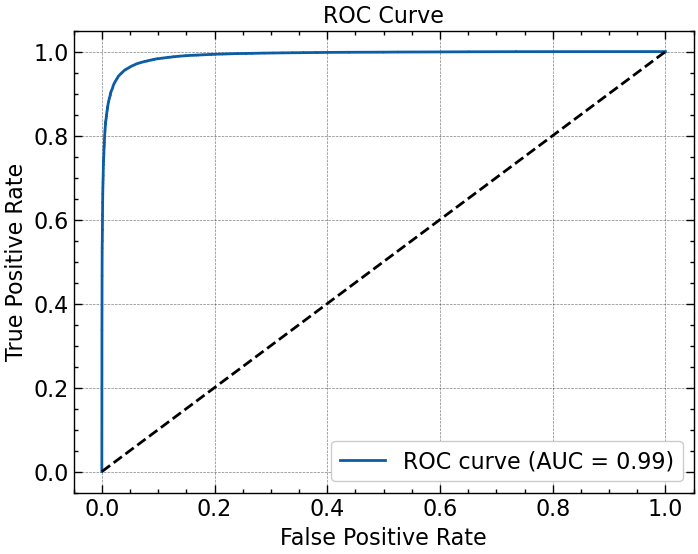

In [30]:

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("Main")
csv_file = "citation_dataset.csv"

df_sample = pd.read_csv(csv_file, nrows=1)
sample_embedding = ast.literal_eval(df_sample.iloc[0]['embedding1'])
embedding_dim = len(sample_embedding)
logger.info(f"Computed embedding dimension: {embedding_dim}")

dataset = CitationDataset(csv_file)
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

model_type = 'cnn'  
if model_type == 'attention':
    model = CitationAttentionNet(embedding_dim=embedding_dim, nhead=2, num_layers=1, hidden_dim=128, dropout=0.2)
    logger.info("Using CitationAttentionNet")
elif model_type == 'cnn':
    model = CitationCNN(embedding_dim=embedding_dim, num_filters=64, kernel_size=(2, 3), hidden_dim=128, dropout=0.2)
    logger.info("Using CitationCNN")
else:
    raise ValueError("Unknown model type")

trainer = Trainer(model, train_dataset, batch_size=256, lr=1e-3, epochs=3)
trainer.train()
auc = trainer.evaluate(test_dataset)
torch.save(model.state_dict(), "citation_model.pth")
logger.info(f"Model saved as citation_model.pth with AUC: {auc:.4f}")


In [31]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score


def compute_metrics(model, dataset, threshold=0.5, batch_size=256, device=None):
    """
    Compute accuracy and confusion matrix for the given model and dataset.
    """
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for emb1, emb2, labels in tqdm(loader, desc="Computing metrics", leave=False):
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
            outputs = model(emb1, emb2)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    binary_preds = (np.array(all_preds) >= threshold).astype(int)
    true_labels = np.array(all_labels).astype(int)
    acc = accuracy_score(true_labels, binary_preds)
    cm = confusion_matrix(true_labels, binary_preds)
    return acc, cm

acc, cm = compute_metrics(model, test_dataset, threshold=0.5, batch_size=256)
logger.info(f"Test Accuracy: {acc:.4f}")
logger.info(f"Confusion Matrix:\n{cm}")

INFO:Main:Test Accuracy: 0.9565                                     
INFO:Main:Confusion Matrix:
[[48213  1617]
 [ 2737 47433]]


## Optimization

- Train on more epochs (not done)
- Optimize treshold for evaluation

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x3b5f2c2f0>


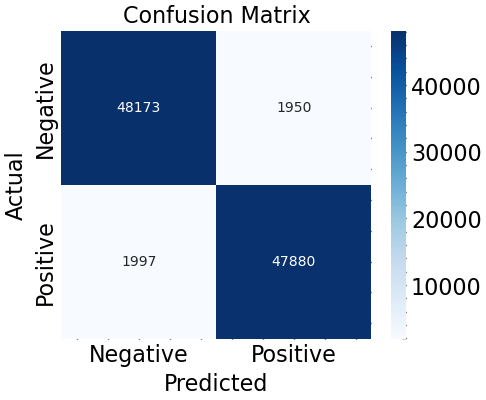

INFO:Main:Best Threshold: 0.3058
INFO:Main:Test Accuracy: 0.9605
INFO:Main:Confusion Matrix:
[[48173  1950]
 [ 1997 47880]]


In [37]:
def compute_metrics_optimized(model, dataset, threshold=None, batch_size=256, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for emb1, emb2, labels in tqdm(loader, desc="Computing metrics", leave=False):
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
            outputs = model(emb1, emb2)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    true_labels = np.array(all_labels).astype(int)

    fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
    if threshold is None:
        best_idx = np.argmax(tpr - fpr)
        threshold = thresholds[best_idx]

    binary_preds = (all_preds >= threshold).astype(int)
    acc = accuracy_score(true_labels, binary_preds)
    cm = confusion_matrix(true_labels, binary_preds)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.show()

    return acc, cm, threshold

acc, cm, best_threshold = compute_metrics_optimized(model, test_dataset, batch_size=256)
logger.info(f"Best Threshold: {best_threshold:.4f}")
logger.info(f"Test Accuracy: {acc:.4f}")
logger.info(f"Confusion Matrix:\n{cm}")


# 5. Demos 

## Demo for our 'abstract'

In [1]:
import logging
import ast
import torch
import pandas as pd
from tqdm import tqdm, trange
from sentence_transformers import SentenceTransformer

def run_demo(new_text, df_path="abstract_embeddings.csv", model_path="citation_model.pth", model_type="cnn"):
    logger = logging.getLogger("Demo")
    logger.info("Starting demo for citation prediction.")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    steps = 8
    with tqdm(total=steps, desc="Demo Progress", leave=True) as overall_pbar:
        df = pd.read_csv(df_path)
        logger.info(f"Loaded dataset with {len(df)} papers.")
        overall_pbar.update(1)
        
        sample_embedding = ast.literal_eval(df.iloc[0]['abstract_embeddings'])
        embedding_dim = len(sample_embedding)
        logger.info(f"Computed embedding dimension from dataset: {embedding_dim}")
        overall_pbar.update(1)
        
        if model_type == "cnn":
            model = CitationCNN(
                embedding_dim=embedding_dim,
                num_filters=64,
                kernel_size=(2, 3),
                hidden_dim=128,
                dropout=0.2
            )
            logger.info("Using CitationCNN for demo.")
        elif model_type == "attention":
            model = CitationAttentionNet(
                embedding_dim=embedding_dim,
                nhead=2,
                num_layers=1,
                hidden_dim=128,
                dropout=0.2
            )
            logger.info("Using CitationAttentionNet for demo.")
        else:
            model = CitationNet(embedding_dim=embedding_dim, hidden_dim=128)
            logger.info("Using CitationNet for demo.")
        overall_pbar.update(1)
        
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        logger.info("Loaded trained citation model.")
        overall_pbar.update(1)
        
        sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        logger.info("Loaded SentenceTransformer model for text embedding.")
        overall_pbar.update(1)
        
        new_emb = sentence_model.encode(new_text)
        new_emb_tensor = torch.tensor(new_emb, dtype=torch.float).unsqueeze(0).to(device)
        logger.info("Embedded new text.")
        overall_pbar.update(1)
        
        probabilities = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing probabilities", leave=False):
            paper_emb = torch.tensor(ast.literal_eval(row['abstract_embeddings']), dtype=torch.float).unsqueeze(0).to(device)
            with torch.no_grad():
                prob = model(new_emb_tensor, paper_emb).item()
            probabilities.append(prob)
        df['citation_probability'] = probabilities
        overall_pbar.update(1)
        
        top10 = df.sort_values(by='citation_probability', ascending=False).head(10)
        overall_pbar.update(1)
    
    logger.info("Top 10 citation predictions:")
    for _, row in top10.iterrows():
        logger.info(f"Paper ID: {row['id']}, Probability: {row['citation_probability']:.4f}, Abstract: {row['abstract']}")
    
    return top10


In [6]:
logging.basicConfig(level=logging.DEBUG)
new_text = """The number of academic publications has grown exponentially in recent years. Fac-
tors such as the COVID-19 pandemic and the rapid advancement of generative and
large language models have contributed to a surge in published research, with the
number of indexed articles increasing from 1.92 million in 2016 to 2.82 million
(Scopus & Web of Science) [2]. This rapid expansion has made it increasingly chal-
lenging to identify relevant work, influential authors, and impactful studies. More
generally, analysing the content of research papers is needed as it provides a broader
picture on the currents in research and the new research trends. As noted by Brainard
(2024), the increasing pressure to publish has led to concerns about the quality of
scientific output, as the proliferation of papers risks diluting meaningful contribu-
tions, making it increasingly difficult to identify truly impactful research. [8] In
this study, we address this issue by proposing a broad natural language analysis of
academic literature. Our approach aims to systematically identify relevant authors,
key publications, and potential conferences aligned with a given research topic. To
achieve this, we analyze citation and authorship networks and abstract similarities,
leveraging different text processing techniques to extract meaningful patterns from
the growing body of scientific literature."""
top10_results = run_demo(new_text, model_path="citation_model.pth", model_type="cnn")
print(top10_results[['id', 'citation_probability', 'abstract']])

INFO:Demo:Starting demo for citation prediction.
Demo Progress:  12%|█▎        | 1/8 [00:45<05:20, 45.76s/it]INFO:Demo:Computed embedding dimension from dataset: 384
INFO:Demo:Using CitationCNN for demo.
INFO:Demo:Loaded trained citation model.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /sentence-transformers/all-MiniLM-L6-v2/resolve/main/config_sentence_transformers.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /sentence-transformers/all-MiniLM-L6-v2/resolve/main/README.md HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:Demo:Embedded new text.
Demo Progress: 100%|██████████| 8/8 [11:34<00:00, 86.84s/it] 
INFO:Demo:Top 10 citation predictions:
INFO:Demo:Paper ID: 8ba045eb-37e7-46e1-b757-bd42627789e0, Probability: 0.9999, Abstract: Title: Analyzing the Dynamics of Research by Extracting Key Aspects of Scientific Papers

Venue: international joint conference on natural language processing

Abstract: We present a method for characterizing a research work in terms of its focus, domain of application, and techniques used. We show how tracing these aspects over time provides a novel measure of the influence of research communities on each other. We extract these characteristics by matching semantic extraction patterns, learned using bootstrapping, to the dependency trees of sentences in an article’s
INFO:Demo:Paper ID: f95c84c7-3042-41f1-ac84-ed7f228349de, Probability: 0.9998, Abstract: Title: Editorial for the First Workshop on Mining Scientific Papers: Computational Linguistics and Bibliometrics

Venu

                                          id  citation_probability  \
451118  8ba045eb-37e7-46e1-b757-bd42627789e0              0.999882   
470739  f95c84c7-3042-41f1-ac84-ed7f228349de              0.999795   
516524  c0f0e8c9-13c9-4001-a99f-7b52d8aeba69              0.999794   
561042  7c0ebbcc-7a03-4551-8534-54dbce623381              0.999783   
178493  999f0e47-b494-48bf-a5a8-48e7bdbad3f6              0.999780   
510253  93591b24-e1b8-47a8-b857-c8f8d7f5b57c              0.999775   
262253  be9cb73a-0366-4a46-b839-cd1a1c6103a7              0.999762   
576414  16c7a362-ff43-46a9-9ef2-83a9d4b589a7              0.999757   
451774  cbb14c64-cda3-4d07-8daa-601bbe9df562              0.999710   
525058  9a5afdc1-7afe-4fe3-9227-74c96cd6e7ad              0.999691   

                                                 abstract  
451118  Title: Analyzing the Dynamics of Research by E...  
470739  Title: Editorial for the First Workshop on Min...  
516524  Title: Insights from Mining Eleven Years 

## Interactive visual for PCA on embeddings

In [8]:
from src.visual import PCAVisualization


df = pd.read_csv('output/abstract_embeddings.csv')

df.head()

df = df.sort_values(by='year', ascending=True).head(100000)

logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
visualization = PCAVisualization(df)
visualization.run()

INFO:root:Converting string embeddings to list.
100%|██████████| 100000/100000 [00:07<00:00, 13391.11it/s]
INFO:root:Performing PCA.
INFO:root:Computing 2D PCA with shape (100000, 384)
INFO:root:2D PCA done. Computing 3D PCA.
INFO:root:3D PCA done.
INFO:root:Running Dash app.
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 127.0.0.1:8050
DEBUG:urllib3.connectionpool:http://127.0.0.1:8050 "GET /_alive_90ed0d6d-d767-4874-9d35-0f6504e75a7d HTTP/11" 200 5


INFO:root:Updating plots.
